<a href="https://colab.research.google.com/github/revanthp/emerging_traffic_patterns/blob/master/emergent_traffic_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emergent Traffic Patterns

In [14]:
import random
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Declare global variables
L = 30000
V_MAX = 5
INIT_N_GAP_MAX = 100 # Chosen randomly for max gap.
MAX_ITER = 3 * 10**6
TRANSIENT = 5 * 10**5 # Number of iterations after which we start recording
STEP = 2500 # Record for every 2500 iterations
SEED = 1234 # to ensure every run is the same. 
RHO_MIN = 0.04
RHO_MAX = 0.14
RHO_STEPS = 11

In [0]:
# spare code for testing
# N = 6
# # temp_vel = np.random.randint(low=0, high=V_MAX + 1, size = N)
# # temp_ngap = np.random.randint(low=0, high=round(L-N), size=N)
# # temp_ngap = np.round(temp_ngap * ((L-N) / np.sum(temp_ngap)))

# temp_vel =np.array([5, 5, 3, 2, 4, 5])
# temp_ngap = np.array([5, 6, 4, 6, 3, 2])

# # assert all(update_velocity(temp_vel, temp_ngap) == update_velocity_vectorized(temp_vel, temp_ngap))
# np.random.seed(1234)
# [update_velocity(v, n) for v, n in zip(temp_vel, temp_ngap)]

In [0]:
# Simulation
def simulation(rho=0.04):
  
    print('Running simulation for rho = {0}'.format(rho))
  
    # set random seed to keep things consistent between runs
    np.random.seed(1234)
    
    # number of cars for a rho
    N = np.int(rho * L)

    # randomly generate velocities for each car
    v = np.random.randint(low=0, high=(V_MAX + 1), size=N).reshape((1, -1))
    
    # randomly generate the gap in front of each car
    ngaps = np.random.randint(low=0, high=(L - N), size=N).reshape((1, -1))
    
    # normalize the gaps to sum to (length of car - total num. of car).
    ngaps = np.round(ngaps * (L-N) / np.sum(ngaps)).astype(int).reshape((1, -1))

    # list to store current_density at every 2500 time steps.
    j_i = []
  
    # update car position max. iteration times.
    for iter_ in range(MAX_ITER):

        # boolean array identifying cars about to accelerate as True and rest as False.
        acc_mask = (ngaps >= (v + 1)) & (v < V_MAX)
        
        # Update velocity for accelerating cars.
        v[acc_mask] += np.random.randint(0, 2, np.sum(acc_mask))

        # boolean array identifying cars about to deaccelerate as True and rest as False.
        deacc_mask = (ngaps <= (v - 1)) & ~acc_mask

        # Update velocity for deaccelerating cars.
        v[deacc_mask] = np.fmax(0, ngaps[deacc_mask] - 1 * np.random.randint(0, 2, np.sum(deacc_mask)))

        # update ngaps for each car.
        ngaps = (ngaps - v) + np.append(v[1:], np.random.randint(0, V_MAX + 1, 1).squeeze())

        # if all cars are moving at maximum speed and have enough gap to move, 
        # then we have reached a stationary state and j = rho * V_MAX,
        # and we stop the simulation.
        if np.all(v == V_MAX) & np.all(ngaps >= V_MAX):
            print({'Early stopping triggered at iteration {0} for rho={1}.'.format(iter_, rho)})
            return {rho: np.round(rho * V_MAX, 3)}
            

        # Record current denisty after TRANSIENT and for every 2500 steps.
        if (iter_ >= TRANSIENT) and ((iter_ % STEP) == 0):
            j_i.append(np.sum(v) / L) # save the average_velocity

    # Return the average of current densities for a given rho
    return {rho:np.round(np.mean(j_i), 3)}

In [0]:
# Parallize code. 
# Simulation for each rho is run on a separate core.
p = Pool(RHO_STEPS)
out = p.map(simulation, np.linspace(RHO_MIN, RHO_MAX, RHO_STEPS))

Running simulation for rho: 0.06
Running simulation for rho: 0.04
Running simulation for rho: 0.14
Running simulation for rho: 0.09
Running simulation for rho: 0.13
Running simulation for rho: 0.07
Running simulation for rho: 0.12
Running simulation for rho: 0.11000000000000001
Running simulation for rho: 0.1
Running simulation for rho: 0.05
Running simulation for rho: 0.08


In [0]:
# Convert list of dictionary to dictionary.
results = dict()
[results.update(x) for x in out];
results

{0.04: 0.1,
 0.05: 0.125,
 0.06: 0.15,
 0.07: 0.175,
 0.08: 0.2,
 0.09: 0.225,
 0.1: 0.25,
 0.11000000000000001: 0.275,
 0.12: 0.3,
 0.13: 0.325,
 0.14: 0.35}

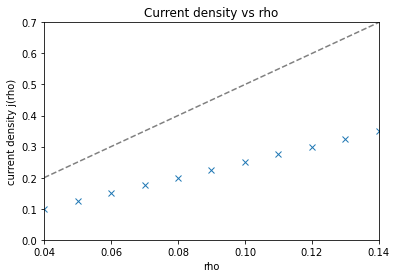

In [0]:
# Plotting.
plt.plot(list(results.keys()), list(results.values()), 'x')
plt.plot([RHO_MIN, RHO_MAX], [RHO_MIN * V_MAX, RHO_MAX * V_MAX], '--', color='grey')
plt.xlim([RHO_MIN, RHO_MAX])
plt.ylim([0, RHO_MAX * V_MAX])
plt.title('Current density vs rho')
plt.xlabel('rho')
plt.ylabel('current density j(rho)')
plt.show()

In [46]:
out = simulation(0.04)

Running simulation for rho = 0.04
